Please mount the google drive to download the baseline code for NeuralMMO


In [ ]:
import os
assert os.path.exists("/content/drive/MyDrive"), "Google Drive not mounted"

work_dir = "/content/drive/MyDrive/nmmo/"

In [ ]:
!pip install nmmo pufferlib==0.4.3 > /dev/null
!pip show nmmo  # should be 2.0.3
!pip show pufferlib # should be 0.4.3

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.86 requires numpy>=1.24.1, but you have numpy 1.23.3 which is incompatible.
tensorflow 2.15.0 requires numpy<2.0.0,>=1.23.5, but you have numpy 1.23.3 which is incompatible.
Name: nmmo
Version: 2.0.4
Summary: Neural MMO is a platform for multiagent intelligence research inspired by Massively Multiplayer Online (MMO) role-playing games. Documentation hosted at neuralmmo.github.io.
Home-page: https://github.com/neuralmmo/environment
Author: Joseph Suarez
Author-email: jsuarez@mit.edu
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: dill, gym, imageio, numpy, ordered-set, pettingzoo, psutil, py, pylint, pytest, pytest-benchmark, scipy, tqdm, vec-noise
Required-by: 
Name: pufferlib
Version: 0.4.3
Summary: PufferAI LibraryPufferAI's library of RL tools and utilities
Home-page: https://g


For the next code block, if working directory (work_dir) is not created, and baseline code is not downloaded, please uncomment the two corresponding lines.

After running for one time, the baseline code for NeuralMMO should be contained in the mounted google drive. Then the two lines of code can be commented.

In [ ]:
# Create the work directory, download the baselines code
# %mkdir $work_dir
%cd $work_dir
# !git clone https://github.com/neuralmmo/baselines --depth=1
%cd baselines

# Create a requirements_colab.txt
with open(work_dir+'baselines/requirements_colab.txt', "w") as f:
  f.write("""
accelerate==0.21.0
bitsandbytes==0.41.1
dash==2.11.1
openelm
pandas
plotly==5.15.0
psutil==5.9.3
ray==2.6.1
scikit-learn==1.3.0
tensorboard==2.11.2
tiktoken==0.4.0
torch
transformers==4.31
wandb==0.13.7
  """)

/content/drive/MyDrive/nmmo
/content/drive/MyDrive/nmmo/baselines


In [ ]:
# Install libs to run the baselines
!pip install -r requirements_colab.txt > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.86 requires numpy>=1.24.1, but you have numpy 1.23.3 which is incompatible.
pandas-gbq 0.19.2 requires google-auth-oauthlib>=0.7.0, but you have google-auth-oauthlib 0.4.6 which is incompatible.
pydantic-core 2.16.3 requires typing-extensions!=4.7.0,>=4.6.0, but you have typing-extensions 4.5.0 which is incompatible.
tensorflow 2.15.0 requires numpy<2.0.0,>=1.23.5, but you have numpy 1.23.3 which is incompatible.
tensorflow 2.15.0 requires tensorboard<2.16,>=2.15, but you have tensorboard 2.11.2 which is incompatible.
torchaudio 2.2.1+cu121 requires torch==2.2.1, but you have torch 2.1.2 which is incompatible.
torchtext 0.17.1 requires torch==2.2.1, but you have torch 2.1.2 which is incompatible.
torchvision 0.17.1+cu121 requires torch==2.2.1, but you have torch 2.1.2 which is incompatible.


In [ ]:
# !python evaluate.py -p policies

In [ ]:
# Just to check if the training flow works
# !python train.py --runs-dir $work_dir --local-mode true

In [ ]:
import nmmo
import numpy as np
# For vectorization of the environment
import pufferlib.emulation
import pufferlib.vectorization
# For creating new customized curriculum
from nmmo.task.base_predicates import CountEvent, InventorySpaceGE, TickGE, norm
from nmmo.task.task_spec import TaskSpec, check_task_spec
# For changing the configuration of the environment and use new curriculum
from reinforcement_learning import config
from environment import Config
import argparse

In [ ]:
env = nmmo.Env()
obs = env.reset()

# Print the number of agents in one environment.
num_agent = env.num_agents
print("Number of agents:", num_agent)
print()

# Print the action space of one agent.
# For each agent, its action space is composed by a dictionary of possible actions.
# For most actions, the last dimension of target means "no action taken".
# For example, there are only 12 inventories in one agent, the 13th dimension is 1
# when no inventory is going to be destroyed.
for key, value in env.action_space(0).items():
    print("Action type:", key, "\t Action value:", value)
print()

# Print the observation space of one agent.
for key, value in env.observation_space(0).items():
    print("Observation type:", key, " \tObservation value:", value)
# Print the content of ActionTargets from observation space.
for key, value in env.observation_space(0)["ActionTargets"].items():
    print("Action type:", key, "\t Action target:", value)

for i in range(len(env.tasks)):
    print(env.tasks[i].name)

env.close()

Number of agents: 128

Action type: Attack 	 Action value: Dict(Style:Discrete(3), Target:Discrete(101))
Action type: Buy 	 Action value: Dict(MarketItem:Discrete(1025))
Action type: Comm 	 Action value: Dict(Token:Discrete(50))
Action type: Destroy 	 Action value: Dict(InventoryItem:Discrete(13))
Action type: Give 	 Action value: Dict(InventoryItem:Discrete(13), Target:Discrete(101))
Action type: GiveGold 	 Action value: Dict(Price:Discrete(99), Target:Discrete(101))
Action type: Move 	 Action value: Dict(Direction:Discrete(5))
Action type: Sell 	 Action value: Dict(InventoryItem:Discrete(13), Price:Discrete(99))
Action type: Use 	 Action value: Dict(InventoryItem:Discrete(13))

Observation type: ActionTargets  	Observation value: Dict(Attack:Dict(Style:Box(0, 1, (3,), int8), Target:Box(0, 1, (101,), int8)), Buy:Dict(MarketItem:Box(0, 1, (1025,), int8)), Comm:Dict(Token:Box(0, 1, (50,), int8)), Destroy:Dict(InventoryItem:Box(0, 1, (13,), int8)), Give:Dict(InventoryItem:Box(0, 1, (13,)

In [ ]:
# Change the configuration of the environment and use a new comprehensive curriculum

parser = argparse.ArgumentParser()
attrs = config.Config.asdict()
for attr, value in attrs.items():
    arg_name = f'--{attr.replace("_", "-")}'
    parser.add_argument(
        arg_name,
        dest=attr,
        type=type(value) if value is not None else str,
        default=value,
        help=f"{arg_name} (default: {value})"
    )
args = parser.parse_args("")

BASELINE_CURRICULUM_FILE = "reinforcement_learning/curriculum_with_embedding.pkl"
args.tasks_path = BASELINE_CURRICULUM_FILE

env = nmmo.Env(Config(args))
obs = env.reset()

# Print the number of agents in one environment.
num_agent = env.num_agents
print("Number of agents:", num_agent)
print()

# Print the action space of one agent.
# For each agent, its action space is composed by a dictionary of possible actions.
# For most actions, the last dimension of target means "no action taken".
# For example, there are only 12 inventories in one agent, the 13th dimension is 1
# when no inventory is going to be destroyed.
for key, value in env.action_space(0).items():
    print("Action type:", key, "\t Action value:", value)
print()

# Print the observation space of one agent.
for key, value in env.observation_space(0).items():
    print("Observation type:", key, " \tObservation value:", value)
# Print the content of ActionTargets from observation space.
for key, value in env.observation_space(0)["ActionTargets"].items():
    print("Action type:", key, "\t Action target:", value)

for i in range(len(env.tasks)):
    print(env.tasks[i].name)

env.close()

Number of agents: 128

Action type: Attack 	 Action value: Dict(Style:Discrete(3), Target:Discrete(101))
Action type: Buy 	 Action value: Dict(MarketItem:Discrete(1025))
Action type: Destroy 	 Action value: Dict(InventoryItem:Discrete(13))
Action type: Give 	 Action value: Dict(InventoryItem:Discrete(13), Target:Discrete(101))
Action type: GiveGold 	 Action value: Dict(Price:Discrete(99), Target:Discrete(101))
Action type: Move 	 Action value: Dict(Direction:Discrete(5))
Action type: Sell 	 Action value: Dict(InventoryItem:Discrete(13), Price:Discrete(99))
Action type: Use 	 Action value: Dict(InventoryItem:Discrete(13))

Observation type: ActionTargets  	Observation value: Dict(Attack:Dict(Style:Box(0, 1, (3,), int8), Target:Box(0, 1, (101,), int8)), Buy:Dict(MarketItem:Box(0, 1, (1025,), int8)), Destroy:Dict(InventoryItem:Box(0, 1, (13,), int8)), Give:Dict(InventoryItem:Box(0, 1, (13,), int8), Target:Box(0, 1, (101,), int8)), GiveGold:Dict(Price:Box(0, 1, (99,), int8), Target:Box(0, 

In [ ]:
# It is very difficult to deal with such a big observation & action space.
# And it is very difficult to manage the corresponding dictionaries.
# So pufferlib is used to flatten observation & action space.
# Pufferlib is actually based on policy-gradient RL.
# We want to implement DQN here, so we only use the verctorization tool from it.
def nmmo_creator():
    env = nmmo.Env()
    return pufferlib.emulation.PettingZooPufferEnv(env=env)

vec = pufferlib.vectorization.Serial
envs = vec(nmmo_creator)

envs.async_reset()
observation, reward, done, info = envs.recv()

In [ ]:
# The final observation space is just a vector with dimension shown below
print("Observation space dimension:", np.prod(envs.single_observation_space.shape))

# The final action space is an integer vector with elements' range shown below
print("Action vector range:", envs.single_action_space.nvec)

Observation space dimension: 26085
Action vector range: [   3  101 1025   50   13   13  101   99  101    5   13   99   13]


In [ ]:
# Random policy
max_num_timesteps=10
reward_list = []
for i in range(max_num_timesteps):
    low = np.zeros(len(envs.single_action_space.nvec), dtype=int)
    high = np.array(envs.single_action_space.nvec, dtype=int)
    random_action = np.random.randint(0, high=high, size=(128, 13))
    print("----- Agent (ID=1) Info -----")
    nmmo_env = envs.envs[0].envs[0].env
    print("Current Tick:", nmmo_env.realm.tick)
    print("Task:", nmmo_env.tasks[0].name)
    print("Task complete:", nmmo_env.tasks[0].completed)
    print("Agent alive:", nmmo_env.tasks[0].assignee[0] in nmmo_env.realm.players)
    print("-----------------------------")
    o, r, d, i = envs.step(random_action)
    reward_list.append(r[0])
envs.close()
print(reward_list)

----- Agent (ID=1) Info -----
Current Tick: 0
Task: (OngoingTask_eval_fn:(StayAlive_(1,))_assignee:(1,))
Task complete: False
Agent alive: True
-----------------------------
----- Agent (ID=1) Info -----
Current Tick: 1
Task: (OngoingTask_eval_fn:(StayAlive_(1,))_assignee:(1,))
Task complete: True
Agent alive: True
-----------------------------
----- Agent (ID=1) Info -----
Current Tick: 2
Task: (OngoingTask_eval_fn:(StayAlive_(1,))_assignee:(1,))
Task complete: True
Agent alive: True
-----------------------------
----- Agent (ID=1) Info -----
Current Tick: 3
Task: (OngoingTask_eval_fn:(StayAlive_(1,))_assignee:(1,))
Task complete: True
Agent alive: True
-----------------------------
----- Agent (ID=1) Info -----
Current Tick: 4
Task: (OngoingTask_eval_fn:(StayAlive_(1,))_assignee:(1,))
Task complete: True
Agent alive: True
-----------------------------
----- Agent (ID=1) Info -----
Current Tick: 5
Task: (OngoingTask_eval_fn:(StayAlive_(1,))_assignee:(1,))
Task complete: True
Agent ali

In [ ]:
import torch
from torch.optim.lr_scheduler import _LRScheduler

%matplotlib inline

import matplotlib.pyplot as plt

import seaborn as sns
from tqdm.notebook import tqdm
from typing import List, Tuple, Deque, Optional, Callable

import itertools
import collections

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class QNetwork(torch.nn.Module):
    def __init__(self, n_observations: int, n_actions: int, nn_l1: int, nn_l2: int):
        super(QNetwork, self).__init__()
        self.layer1 = torch.nn.Linear(n_observations, nn_l1)
        self.layer2 = torch.nn.Linear(nn_l1, nn_l2)
        self.layer3 = torch.nn.Linear(nn_l2, n_actions)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.nn.functional.relu(self.layer1(x))
        x = torch.nn.functional.relu(self.layer2(x))
        x = self.layer3(x)
        return x

class EpsilonGreedy:
    def __init__(self,
                 epsilon_start: float,
                 epsilon_min: float,
                 epsilon_decay: float,
                 action_n: int,
                 q_network: torch.nn.Module):
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.action_n = action_n
        self.q_network = q_network

    def __call__(self, state: np.ndarray) -> np.int64:
        random_number = np.random.rand()
        if random_number < self.epsilon:
            action = np.random.randint(0, self.action_n)
        else:
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            q_values = self.q_network(state_tensor)
            action = torch.argmax(q_values, dim=1).item()

        return action

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

class MinimumExponentialLR(torch.optim.lr_scheduler.ExponentialLR):
    def __init__(self,
                 optimizer: torch.optim.Optimizer,
                 lr_decay: float,
                 last_epoch: int = -1,
                 min_lr: float = 1e-6):
        self.min_lr = min_lr
        super().__init__(optimizer, lr_decay, last_epoch=-1)

    def get_lr(self) -> List[float]:
        return [
            max(base_lr * self.gamma ** self.last_epoch, self.min_lr)
            for base_lr in self.base_lrs
        ]

In [ ]:
# Q-Network without training
action_n_vec = np.array(envs.single_action_space.nvec)
dim_observation = envs.single_observation_space.shape[0]
q_networks = []
for i in range(action_n_vec.shape[0]):
    q_networks.append(QNetwork(dim_observation, action_n_vec[i], 256, 16).to(device))

max_num_timesteps=10
reward_list = []
vec = pufferlib.vectorization.Serial
envs = vec(nmmo_creator)
envs.async_reset()
o, r, d, i = envs.recv()
for i in range(max_num_timesteps):
    o = torch.Tensor(o).to(device)
    action_multi_agent = []
    for agent_id in range(128):
        current_action = []
        for action_id in range(len(q_networks)):
            q_values = q_networks[action_id].forward(o[agent_id])
            action = torch.argmax(q_values).item()
            current_action.append(action)
        action_multi_agent.append(current_action)
    print("----- Agent (ID=1) Info -----")
    nmmo_env = envs.envs[0].envs[0].env
    print("Current Tick:", nmmo_env.realm.tick)
    print("Task:", nmmo_env.tasks[0].name)
    print("Task complete:", nmmo_env.tasks[0].completed)
    print("Agent alive:", nmmo_env.tasks[0].assignee[0] in nmmo_env.realm.players)
    print("-----------------------------")
    o, r, d, i = envs.step(action_multi_agent)
    reward_list.append(np.mean(r))
envs.close()
print(reward_list)

----- Agent (ID=1) Info -----
Current Tick: 0
Task: (OngoingTask_eval_fn:(StayAlive_(1,))_assignee:(1,))
Task complete: False
Agent alive: True
-----------------------------
----- Agent (ID=1) Info -----
Current Tick: 1
Task: (OngoingTask_eval_fn:(StayAlive_(1,))_assignee:(1,))
Task complete: True
Agent alive: True
-----------------------------
----- Agent (ID=1) Info -----
Current Tick: 2
Task: (OngoingTask_eval_fn:(StayAlive_(1,))_assignee:(1,))
Task complete: True
Agent alive: True
-----------------------------
----- Agent (ID=1) Info -----
Current Tick: 3
Task: (OngoingTask_eval_fn:(StayAlive_(1,))_assignee:(1,))
Task complete: True
Agent alive: True
-----------------------------
----- Agent (ID=1) Info -----
Current Tick: 4
Task: (OngoingTask_eval_fn:(StayAlive_(1,))_assignee:(1,))
Task complete: True
Agent alive: True
-----------------------------
----- Agent (ID=1) Info -----
Current Tick: 5
Task: (OngoingTask_eval_fn:(StayAlive_(1,))_assignee:(1,))
Task complete: True
Agent ali

In [ ]:
import random
class ReplayBuffer:
    def __init__(self, capacity: int):
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state: np.ndarray, action: np.int64, reward: float, next_state: np.ndarray, done: bool):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size: int) -> Tuple[np.ndarray, float, float, np.ndarray, bool]:
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return np.array(states), actions, rewards, np.array(next_states), dones

    def __len__(self):
        return len(self.buffer)

In [ ]:
def train_dqn2_agent(q_networks,
                     target_q_networks,
                     optimizers,
                     loss_fn,
                     device,
                     lr_schedulers,
                     num_episodes,
                     gamma,
                     batch_size,
                     target_q_network_sync_period) -> List[float]:

    iteration = 0
    episode_reward_list = []

    replay_buffers = []
    for i in range(action_n_vec.shape[0]):
        replay_buffers.append(ReplayBuffer(1000))

    for episode_index in tqdm(range(1, num_episodes)):
        vec = pufferlib.vectorization.Serial
        envs = vec(nmmo_creator)
        envs.async_reset()
        o, r, d, i = envs.recv()

        episode_reward = 0

        for t in range(20):
            o_tensor = torch.Tensor(o).to(device)
            action_multi_agent = []
            for agent_id in range(128):
                current_action = []
                for action_id in range(len(q_networks)):
                    q_values = q_networks[action_id].forward(o_tensor[agent_id])
                    action = torch.argmax(q_values).item()
                    if np.random.rand() < 0.1:
                        action = np.random.randint(0, len(q_values))
                    current_action.append(action)
                action_multi_agent.append(current_action)

            next_o, r, d, i = envs.step(action_multi_agent)

            for agent_id in range(128):
                for action_id in range(len(q_networks)):
                    replay_buffers[action_id].add(o[agent_id],
                                                  action_multi_agent[agent_id][action_id],
                                                  r[agent_id],
                                                  next_o[agent_id],
                                                  d[agent_id])
            episode_reward += np.mean(r)

            if len(replay_buffers[0]) > batch_size:
                for action_id in range(len(q_networks)):
                    batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = replay_buffers[action_id].sample(batch_size)

                    batch_states_tensor = torch.tensor(batch_states, dtype=torch.float32, device=device)
                    batch_actions_tensor = torch.tensor(batch_actions, dtype=torch.long, device=device)
                    batch_rewards_tensor = torch.tensor(batch_rewards, dtype=torch.float32, device=device)
                    batch_next_states_tensor = torch.tensor(batch_next_states, dtype=torch.float32, device=device)
                    batch_dones_tensor = torch.tensor(batch_dones, dtype=torch.float32, device=device)

                    q_values = q_networks[action_id](batch_states_tensor)
                    next_q_values = target_q_networks[action_id](batch_next_states_tensor)

                    loss = loss_fn(q_values[range(batch_size), batch_actions_tensor],
                                batch_rewards_tensor + gamma * next_q_values.max(1).values * (1 - batch_dones_tensor))

                    optimizers[action_id].zero_grad()
                    loss.backward()
                    optimizers[action_id].step()

                    lr_schedulers[action_id].step()

            if iteration % target_q_network_sync_period == 0:
                for action_id in range(len(q_networks)):
                    target_q_networks[action_id].load_state_dict(q_networks[action_id].state_dict())

            iteration += 1

            o = next_o

        episode_reward_list.append(episode_reward)

    return episode_reward_list

In [ ]:
# Trained with curriculum containing only Staying Alive Task
action_n_vec = np.array(envs.single_action_space.nvec)
dim_observation = envs.single_observation_space.shape[0]

q_networks = []
for i in range(action_n_vec.shape[0]):
    q_networks.append(QNetwork(dim_observation, action_n_vec[i], 256, 16).to(device))

target_q_networks = []
for i in range(action_n_vec.shape[0]):
    current_network = QNetwork(dim_observation, action_n_vec[i], 256, 16).to(device)
    current_network.load_state_dict(q_networks[i].state_dict())
    target_q_networks.append(current_network)

optimizers = []
lr_schedulers = []
for i in range(action_n_vec.shape[0]):
    current_optimizer = torch.optim.AdamW(q_networks[i].parameters(), lr=0.004, amsgrad=True)
    current_scheduler = MinimumExponentialLR(current_optimizer, lr_decay=0.97, min_lr=0.0001)
    optimizers.append(current_optimizer)
    lr_schedulers.append(current_scheduler)

loss_fn = torch.nn.MSELoss()

episode_reward_list = train_dqn2_agent(q_networks,
                                       target_q_networks,
                                       optimizers,
                                       loss_fn,
                                       device,
                                       lr_schedulers,
                                       num_episodes=100,
                                       gamma=0.9,
                                       batch_size=128,
                                       target_q_network_sync_period=30)

  0%|          | 0/99 [00:00<?, ?it/s]

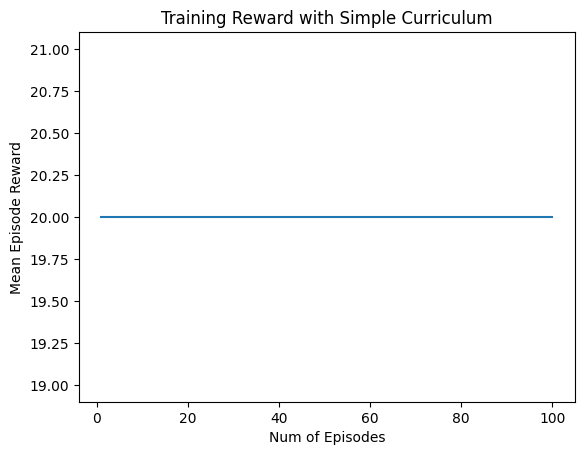

[20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0]


In [ ]:
x = np.linspace(1, 100, 99)
y = episode_reward_list
fig, ax = plt.subplots()

ax.plot(x, y)
plt.xlabel("Num of Episodes")
plt.ylabel("Mean Episode Reward")
plt.title("Training Reward with Simple Curriculum")
plt.show()
print(y)

In [ ]:
parser = argparse.ArgumentParser()
attrs = config.Config.asdict()
for attr, value in attrs.items():
    arg_name = f'--{attr.replace("_", "-")}'
    parser.add_argument(
        arg_name,
        dest=attr,
        type=type(value) if value is not None else str,
        default=value,
        help=f"{arg_name} (default: {value})"
    )
args = parser.parse_args("")

BASELINE_CURRICULUM_FILE = "reinforcement_learning/curriculum_with_embedding.pkl"
args.tasks_path = BASELINE_CURRICULUM_FILE
args.num_envs = 1
args.num_buffers = 1

def nmmo_creator():
    env = nmmo.Env(Config(args))
    return pufferlib.emulation.PettingZooPufferEnv(env=env)

vec = pufferlib.vectorization.Serial
envs = vec(nmmo_creator)

envs.async_reset()
observation, reward, done, info = envs.recv()

print("Observation space dimension:", np.prod(envs.single_observation_space.shape))

print("Action vector range:", envs.single_action_space.nvec)

print(observation.shape)

action_n_vec = np.array(envs.single_action_space.nvec)
dim_observation = envs.single_observation_space.shape[0]

Observation space dimension: 26035
Action vector range: [   3  101 1025   13   13  101   99  101    5   13   99   13]
(128, 26035)


In [ ]:
# Trained with curriculum containing only all different kinds of tasks
q_networks = []
for i in range(action_n_vec.shape[0]):
    q_networks.append(QNetwork(dim_observation, action_n_vec[i], 256, 16).to(device))

target_q_networks = []
for i in range(action_n_vec.shape[0]):
    current_network = QNetwork(dim_observation, action_n_vec[i], 256, 16).to(device)
    current_network.load_state_dict(q_networks[i].state_dict())
    target_q_networks.append(current_network)

optimizers = []
lr_schedulers = []
for i in range(action_n_vec.shape[0]):
    current_optimizer = torch.optim.AdamW(q_networks[i].parameters(), lr=0.004, amsgrad=True)
    current_scheduler = MinimumExponentialLR(current_optimizer, lr_decay=0.97, min_lr=0.0001)
    optimizers.append(current_optimizer)
    lr_schedulers.append(current_scheduler)

loss_fn = torch.nn.MSELoss()

episode_reward_list = train_dqn2_agent(q_networks,
                                       target_q_networks,
                                       optimizers,
                                       loss_fn,
                                       device,
                                       lr_schedulers,
                                       num_episodes=100,
                                       gamma=0.9,
                                       batch_size=128,
                                       target_q_network_sync_period=30)

  0%|          | 0/99 [00:00<?, ?it/s]

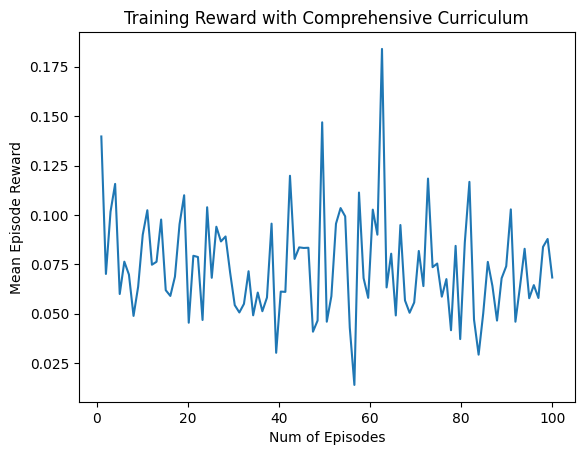

[0.13970455109126984, 0.07014508928571428, 0.10164124503968253, 0.11570033482142857, 0.05999348958333332, 0.07635912698412699, 0.0698170882936508, 0.04891493055555555, 0.06365017361111111, 0.08994698660714291, 0.10238219246031745, 0.0748046875, 0.07630208333333334, 0.09767609126984125, 0.061923363095238104, 0.05901847718253968, 0.06875868055555556, 0.0953125, 0.1099640376984127, 0.045455109126984125, 0.07933593750000001, 0.07871527777777779, 0.04684957837301585, 0.10388640873015874, 0.06819196428571428, 0.0940407986111111, 0.08658854166666663, 0.08910590277777776, 0.07072743055555553, 0.05434895833333333, 0.05065104166666667, 0.05499441964285713, 0.07151041666666666, 0.04921267361111109, 0.060727926587301584, 0.05127604166666667, 0.058203125, 0.09559833829365078, 0.030238839285714286, 0.06121031746031747, 0.061062500000000006, 0.11982266865079365, 0.07773003472222223, 0.08359064980158731, 0.08328683035714284, 0.08339843749999999, 0.04090897817460316, 0.046542286706349204, 0.14686569940

In [ ]:
x = np.linspace(1, 100, 99)
y = episode_reward_list
fig, ax = plt.subplots()

ax.plot(x, y)
plt.xlabel("Num of Episodes")
plt.ylabel("Mean Episode Reward")
plt.title("Training Reward with Comprehensive Curriculum")
plt.show()
print(y)